In [1]:
#| export
verbose                       = None 
show_plots                    = True
reset_kernel                  = None 
pre_configured_case           = True
case_id                       = 7
frequency_factor              = None
frequency_factor_change_alias = True
cuda_device                   = None
check_parameters              = True
example                       = None
move_files                    = None
example                       = None

In [2]:
#| hide 
example    = "kohls"
move_files = False
if move_files:
    import _clean_yaml as yml
    import os
    yml.copy_and_verify_yaml(
        wdb_user    = os.getenv("WANDB_ENTITY", "<>"), 
        wdb_project = os.getenv("WANDB_PROJECT", "<>"),
        example = example,
        verbose = 1
)
    

## Checking input parameters

In [3]:
#| export
if check_parameters:
    print("--- Check parameters ---")
    print(
        "verbose:", verbose,
        "show_plots:",show_plots,
        "reset_kernel:",reset_kernel,
        "pre_configured_case:",pre_configured_case,
        "case_id:",case_id,
        "frequency_factor:", frequency_factor, 
        "frequency_factor_change_alias:", frequency_factor_change_alias,
        "cuda_device:", cuda_device
)

--- Check parameters ---
verbose: None show_plots: True reset_kernel: None pre_configured_case: True case_id: 7 frequency_factor: None frequency_factor_change_alias: True cuda_device: None


## Set default input parameter values ensuring no errors
### Values explained below in their natural execution place

In [4]:
#| export
verbose                       = 1  if verbose is None else verbose
show_plots                    = False if show_plots is None else show_plots
reset_kernel                  = False  if reset_kernel is None else reset_kernel
pre_configured_case           = True if pre_configured_case is None else pre_configured_case
case_id                       = 6 if case_id is None else case_id
frequency_factor              = 1 if frequency_factor is None else frequency_factor
frequency_factor_change_alias = True if frequency_factor_change_alias is None else frequency_factor_change_alias
cuda_device                   = 0 if  cuda_device is None else cuda_device

# Create artifact from time series dataframe
Gets a .tsf or .csv with a time serie, convert int to np.dataframe and loads it to weights and biases (W&B)

## Set-up
Initial notebook setup and specific debugging and pre-configured cases selection
### VsCode update patch
Initial notebook setup when using VSCode

In [5]:
#| export
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


### Debugging variables
- `verbose`. If `> 0` it adds debbuging messages in those functions that allows so (eg. `get_enc_embeddings`)
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `show_plots`. If `True` all plots are shown within the execution of the notebook. Otherwise, none of them will be plotted.

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [6]:
#| export
import dvats.config as cfg_

In [7]:
#| hide
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


In [8]:
#| export 
##### ----- This cell should be substituted by input parameters ------ #####
##### See _ploomber_engine_example_.ipynb
##### Uncomment for direct Notebook execution
#pre_configured_case = False
#case_id = None
#frequency_factor = 1
#frequency_factor_change_alias = True

## Main code


In [9]:
#| export
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from dvats.load import TSArtifact, infer_or_inject_freq
import pickle
import matplotlib
import matplotlib.pyplot as plt
from tsai.data.external import convert_tsf_to_dataframe
from tsai.utils import stack_pad

### Path and Artiffact configurattions
This notebook gets configuration from `config\base.yaml` and `config\01-dataset_artifact.yaml`

In [10]:
#| export
base_path = Path.home()

In [11]:
#| export
config = cfg_.get_artifact_config_sd2a(verbose = 0)
if pre_configured_case: 
    print(f"Pre configured case id: {case_id}")
    cfg_.force_artifact_config_sd2a(
        config = config, 
        id = case_id, 
        verbose = verbose, 
        both = verbose > 0, 
        frequency_factor = frequency_factor, 
        frequency_factor_change_alias = frequency_factor_change_alias
    )
cfg_.show_attrdict(config)

Pre configured case id: 7
freq: 1W -> 1s
artifact_name: gtrends_khols-normalized_yearly -> toy
date_format: %Y-%m-%d %H:%M:%S
joining_train_test: False
missing_values_constant: None
use_wandb: True
data_cols: [0] -> []
date_offset: None
normalize_training: False
data_fpath: ~/data/Time_Series_Chains_Kohls_data.csv -> ~/data/toy.csv
wandb_artifacts_path: ./data/wandb_artifacts
start_date: 2004-01-01
csv_config: {}
time_col: None
range_testing: None
range_training: None
test_split: 0.2
resampling_freq: None
missing_values_technique: None
artifact_name: toy
csv_config: {}
data_cols: []
data_fpath: ~/data/toy.csv
date_format: %Y-%m-%d %H:%M:%S
date_offset: None
freq: 1s
joining_train_test: False
missing_values_technique: None
missing_values_constant: None
normalize_training: False
range_training: None
range_testing: None
resampling_freq: None
start_date: 2004-01-01
test_split: 0.2
time_col: None
use_wandb: True
wandb_artifacts_path: ./data/wandb_artifacts


### Data Extraction

The data is assumed to come as a dataframe, either as a binarized  picke file or
as a csv file. It can also come as a `.tsf` file

#### Check file content (if wanted)

In [12]:
#| hide
if verbose  > 0:
    fpath=os.path.expanduser(config.data_fpath)
    print(fpath)
    try: 
        with open(fpath, 'r') as file:
            for _ in range(13):
                line = file.readline()
                print(line, end='')
        data, _, _, _, _ = convert_tsf_to_dataframe(fpath)
        print("Timestamp", data.start_timestamp)
    except Exception as e:
        print("Error while converting file. Maybe not a tsf: ", e)

/home/macu/data/toy.csv
T1,T2,T3
0.5651174160530583,0.6371797479205732,0.7418217407048813
0.4935134003882223,0.6294149853417309,0.7397310623320076
0.469349983302753,0.5392199104076484,0.7187567854120941
0.4440996674413469,0.5776701391250909,0.7301690144996238
0.3730078021558282,0.5701801791118106,0.7524056920505833
0.4250306471976907,0.5439381598630367,0.7173686807875511
0.353960808869275,0.5968434716370429,0.6828549014634744
0.2995819396437861,0.5281288533936315,0.7013592638393263
0.3044473237066548,0.5656793700127485,0.6411104193217257
0.3270511350770369,0.576548578046155,0.6089596256371969
0.3533461306497062,0.6077293874759166,0.6034718811428907
0.3057938119675714,0.7144243525282192,0.6556284395994489
Error while converting file. Maybe not a tsf:  Missing attribute section. Attribute section must come before data.


#### Extract data

In [13]:
#| hide
config.data_fpath

'~/data/toy.csv'

In [14]:
# -- Restoring toy
#df = pd.read_csv("https://zenodo.org/record/4328047/files/toy.csv?download=1")
#df.to_csv(config.data_fpath, index = False)

In [15]:
! ls ~/data/toy.csv

/home/macu/data/toy.csv


In [16]:
#| export
ext = str(config.data_fpath).split('.')[-1]

if ext == 'pickle':
    df = pd.read_pickle(config.data_fpath)
    
elif ext in ['csv','txt']:
    df = pd.read_csv(config.data_fpath, **config.csv_config)
    
elif ext == 'tsf':
    data, _, _, _, _ = convert_tsf_to_dataframe(os.path.expanduser(config.data_fpath))
    config.update({'start_date': data.start_timestamp[0]}, allow_val_change=True)
    date_format = config.date_format
    df = pd.DataFrame(stack_pad(data.series_value).T)
    
else:
    raise Exception('The data file path has an unsupported extension')


In [17]:
#| hide
if verbose > 0:
    print(f'File loaded successfully')
    print(df.shape)
    display(df.head())

File loaded successfully
(550, 3)


,T1,T2,T3
0,0.565117,0.637180,0.741822
1,0.493513,0.629415,0.739731
2,0.469350,0.539220,0.718757
3,0.444100,0.577670,0.730169
4,0.373008,0.570180,0.752406


#### Set the time column (if any) as index

In [18]:
#| export
if config.time_col is not None:
    if verbose > 0: print("time_col: "+str(config.time_col))
    
    if isinstance(config.time_col, int): 
        if verbose > 0: print("Op 1: time_col int")
        datetime = df.iloc[:, config.time_col]
    
    elif isinstance(config.time_col, list): 
        if verbose > 0: print("Op 2: time_col list")
        datetime = df.iloc[:, config.time_col].apply(lambda x: x.astype(str).str.cat(sep='-'), axis=1)
    
    index = pd.DatetimeIndex(datetime)
    
    if config.date_offset:
        index += config.date_offset
    
    df = df.set_index(index, drop=False)   
    
    #Delete Timestamp col
    col_name = df.columns[config.time_col]
    
    if verbose > 0: print("... drop Timestamp col " + str(col_name))
    
    df = df.drop(col_name, axis=1)
    
if verbose > 0: display(df.head())

,T1,T2,T3
0,0.565117,0.637180,0.741822
1,0.493513,0.629415,0.739731
2,0.469350,0.539220,0.718757
3,0.444100,0.577670,0.730169
4,0.373008,0.570180,0.752406


#### Set dataframe frequency

In [19]:
#| export
df = infer_or_inject_freq(
    df, 
    injected_freq=config.freq, 
    start_date=config.start_date, 
    format=config.date_format
)
if verbose > 0: print(df.index.freq)

<Second>


In [20]:
df.head()

,T1,T2,T3
2004-01-01 00:00:00,0.565117,0.637180,0.741822
2004-01-01 00:00:01,0.493513,0.629415,0.739731
2004-01-01 00:00:02,0.469350,0.539220,0.718757
2004-01-01 00:00:03,0.444100,0.577670,0.730169
2004-01-01 00:00:04,0.373008,0.570180,0.752406


#### Select only the needed variables

In [21]:
#| export
# Subset of variables
if config.data_cols:
    if verbose > 0: print("data_cols: ", config.data_cols)
    df = df.iloc[:, config.data_cols]

if verbose > 0: print(f'Num. variables: {len(df.columns)}')

Num. variables: 3


#### Ensure data integrity

In [22]:
#| export
#Duplicated rows
if verbose > 0: print("df shape before dropping duplicates", df.shape)
df.drop_duplicates()
if verbose > 0: print("df shape after dropping duplicates", df.shape)
# Verificar si hay duplicados en el índice del dataframe
if df.index.duplicated().any():
    raise ValueError("Duplicated index names")

df shape before dropping duplicates (550, 3)
df shape after dropping duplicates (550, 3)


In [23]:
#| export
# Replace the default missing values by np.NaN
if config.missing_values_constant:
    df.replace(config.missing_values_constant, np.nan, inplace=True)

#### Show time series plot

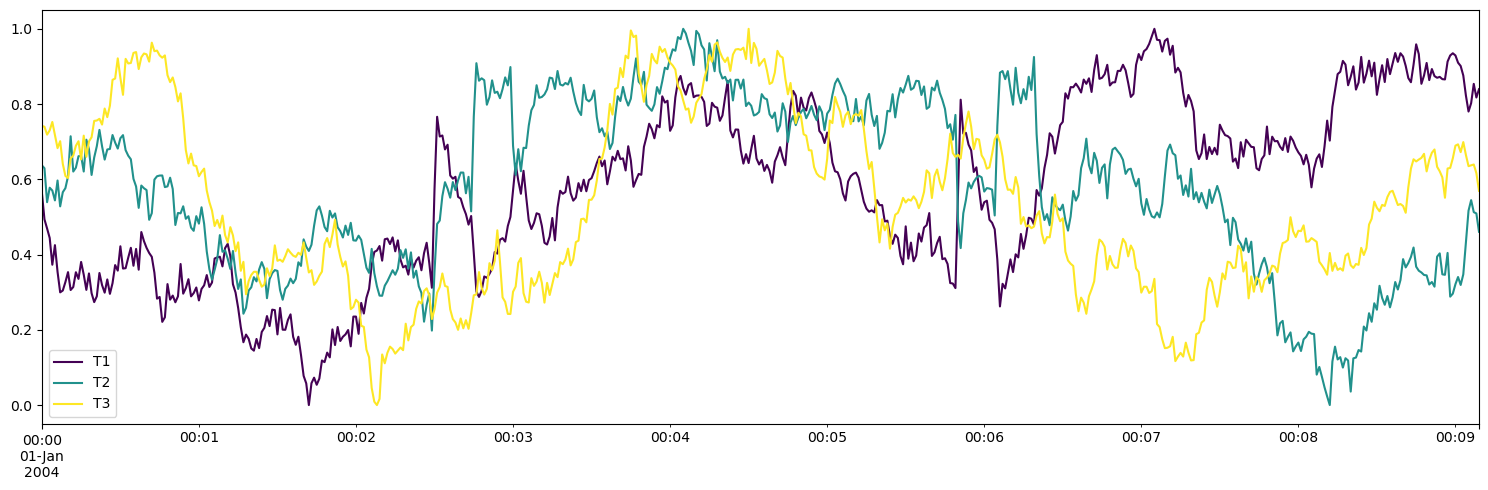

None

In [24]:
#| hide
if show_plots:
    # Show time series plot
    fig, ax = plt.subplots(1, figsize=(15,5), )
    cmap = matplotlib.colormaps.get_cmap('viridis')
    #df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
    df.plot(colormap=cmap, ax=ax) # or use colormap=cmap
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
    plt.tight_layout()
    plt.legend()
    display(plt.show())

### Data Transformation

__Handle Missing Values, Resample and Normalize__

> In this second part, Time Series Artifact (TSArtifact) object can be created and missing values handling techniques, resampling and normalization can be applied.
> 
> This techniques should be applied on the three subsets that must be previously created: training, validation and testing.

#### Training data

##### Build dataframe

In [25]:
#| export
rg = config.range_training

if isinstance(rg, list):
    rg_training = rg
    
elif isinstance(rg, dict):
    rg_training = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])
    
elif config.test_split:
    rg_training = df.index[:math.ceil(len(df) * (1-config.test_split))]

else:
    rg_training = None
    
df_training = df[df.index.isin(rg_training)] if rg_training is not None else df

##### Build training artifact

In [26]:
df.shape

(550, 3)

In [27]:
df_training.shape

(440, 3)

In [28]:
print(config.resampling_freq)

None


In [29]:
###### ESPECIFICO PARA TEST CON KOHL . COMENTAR #####
# Asegúrate de que df_training es una copia y no una vista
#df_training_norm = df_training.copy()

# Normalización de la columna 'volume' al rango [0, 1]
#ts = df_training_norm['volume'].values
#_max_ = np.max(ts)#
#_min_ = np.min(ts)
#print(f"max: {_max_}")
#print(f"min: {_min_}")
#df_training_norm['volume'] = (ts) / (_max_ - _min_)

In [30]:
#df_training_norm.head()

In [31]:
#| hide
#if show_plots:
    # Show time series plot
#    fig, ax = plt.subplots(1, figsize=(15,5), )
#    cmap = matplotlib.colormaps.get_cmap('viridis')
    #df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
#    df_training_norm.plot(colormap=cmap, ax=ax) # or use colormap=cmap
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
#    plt.tight_layout()
#    plt.legend()
#    display(plt.show())

In [32]:
#mean_value = df_training_norm['volume'].mean()
#df_training_norm2 = df_training['volume'] - mean_value

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [34]:
# Minimal Differencing
def minimal_differencing(df, ncol, lag=1):
    df_ = df.copy()
    column_name = df_.columns[ncol]  # Obtén el nombre de la columna
    df_[column_name] = df_[column_name] - df_[column_name].shift(lag)  # Aplica el desplazamiento
    return df_
def normalize_by_window(df, ncol, window_size=12):
    """
    Normaliza localmente una columna de un DataFrame usando ventanas deslizantes.

    Args:
        df (pd.DataFrame): DataFrame que contiene la serie temporal.
        ncol (int): Índice de la columna a normalizar.
        window_size (int): Tamaño de la ventana deslizante.

    Returns:
        pd.DataFrame: DataFrame con la columna normalizada.
    """
    df_ = df.copy()
    series = df_.iloc[:, ncol].values  # Obtén los valores de la columna
    normalized = np.zeros_like(series)  # Crea un array para almacenar los valores normalizados
    
    # Normalización por ventana deslizante
    for i in range(len(series)):
        start = max(0, i - window_size // 2)  # Límite inferior de la ventana
        end = min(len(series), i + window_size // 2 + 1)  # Límite superior de la ventana
        window = series[start:end]  # Extrae la ventana
        # Normaliza el valor actual dentro de la ventana
        normalized[i] = (series[i] - np.min(window)) / (np.max(window) - np.min(window) + 1e-8)
    
    # Reemplaza la columna en el DataFrame con los valores normalizados
    df_.iloc[:, ncol] = normalized
    return df_
def range_normalization(df, ncol, sections=2):
    """
    Divide una columna de un DataFrame en secciones y normaliza cada sección
    de forma independiente.

    Args:
        df (pd.DataFrame): DataFrame que contiene la serie temporal.
        ncol (int): Índice de la columna a normalizar.
        sections (int): Número de secciones en las que dividir la columna.

    Returns:
        pd.DataFrame: DataFrame con la columna normalizada.
    """
    df_ = df.copy()
    series = df_.iloc[:, ncol].values  # Obtén los valores de la columna
    section_size = len(series) // sections  # Tamaño de cada sección
    normalized = np.zeros_like(series)  # Array para almacenar los valores normalizados
    
    # Normalización por secciones
    for i in range(sections):
        start = i * section_size  # Inicio de la sección
        end = (i + 1) * section_size if i < sections - 1 else len(series)  # Fin de la sección
        section = series[start:end]  # Extrae la sección
        min_val, max_val = np.min(section), np.max(section)  # Calcula min y max de la sección
        # Normaliza los valores en la sección
        normalized[start:end] = (section - min_val) / (max_val - min_val + 1e-8)
    
    # Reemplaza la columna con los valores normalizados
    df_.iloc[:, ncol] = normalized
    return df_
#df_training_normalized_by_window = normalize_by_window(df, 0, 17)

In [35]:
#decomposition = seasonal_decompose(df_training['volume'], model='additive', period=12)
#df_training_detrend = pd.DataFrame({'volume': df_training['volume'] - decomposition.trend})
#df_training_denoise = pd.DataFrame({'volume': df_training['volume'] - decomposition.resid})
#df_training = df_training_detrend
#df_training = df_training_denoise
#df_training_normalized_by_range = range_normalization(df_training, 0, sections=int(np.floor(df_training.shape[0]/52)))
#df_training = df_training_normalized_by_range

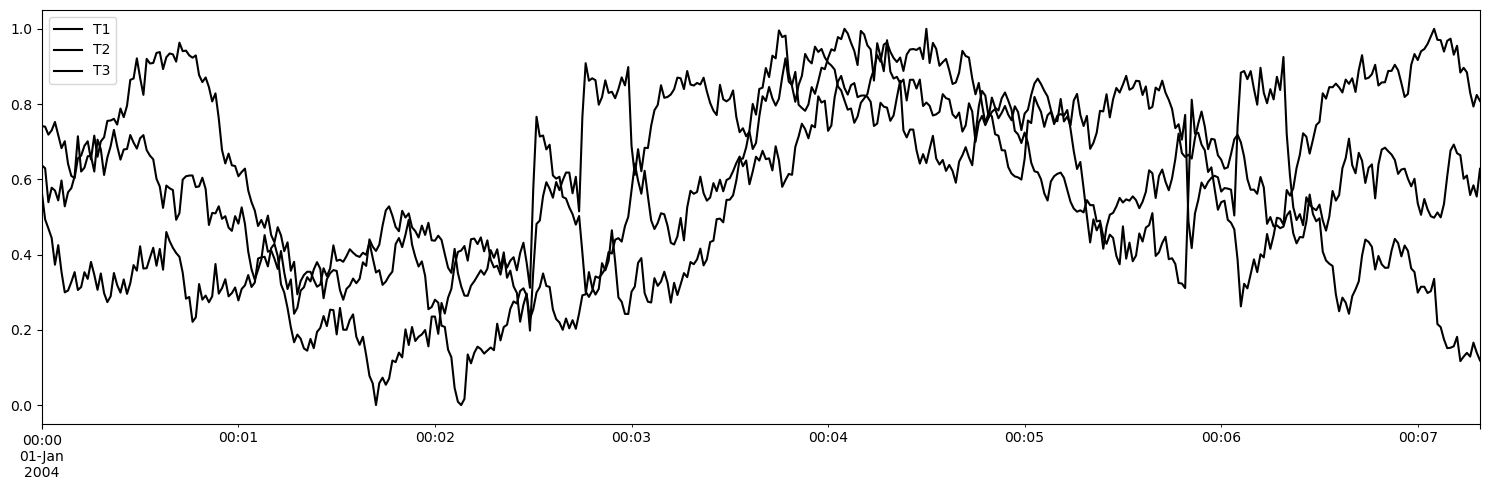

In [36]:
#| hide
if show_plots:
    # Show time series plot
    fig, ax = plt.subplots(1, figsize=(15,5), )
    cmap = matplotlib.colormaps.get_cmap('viridis')
    #df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
    #df_training_denoise.plot(colormap=cmap, ax=ax) # or use colormap=cmap
    df_training.plot(color='black', ax = ax)
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
    plt.tight_layout()
    plt.legend()

In [37]:
#df_training_minimal_diferencing.head()

In [38]:
#| export
training_artifact = TSArtifact.from_df(
    df_training, 
    name                    = config.artifact_name, 
    missing_values_technique= config.missing_values_technique,
    resampling_freq         = config.resampling_freq, 
    normalize               = config.normalize_training, 
    path                    = str(Path.home()/config.wandb_artifacts_path),
    verbose                 = 2
)
if verbose > 0: display(training_artifact.metadata)

[ From df ] sd 2004-01-01 00:00:00, ed 2004-01-01 00:07:19
[ From df ] df_query~(440, 3)
[ From df ] df_missing~(440, 3)
[ From df ] df_resampled~(440, 3)
About to write df to  /home/macu/data/wandb_artifacts/-4339239810985842816


{'TS': {'sd': '2004-01-01 00:00:00',
  'ed': '2004-01-01 00:07:19',
  'created': 'from-df',
  'n_vars': 3,
  'handle_missing_values_technique': 'None',
  'has_missing_values': 'False',
  'n_samples': 440,
  'freq': '<Second>',
  'vars': ['T1', 'T2', 'T3'],
  'hash': '-4339239810985842816'}}

In [39]:
#| export
#Debugging 
if df_training.index.duplicated().any():
    raise ValueError("Duplicated index names")

#### Testing data

##### Build dataframe & artifact

In [40]:
#| export
# Testing data
rg = config.range_testing

if rg or config.test_split:
    
    if isinstance(rg, list):
        rg_testing = rg

    elif isinstance(rg, dict):
        rg_testing = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])

    elif config.test_split:
        rg_testing = df.index[math.ceil(len(df) * (1 - config.test_split)):]

    else:
        rg_testing = None
    
    df_testing = df[df.index.isin(rg_testing)]
    testing_artifact = TSArtifact.from_df(df_testing,
                                          name=config.artifact_name, 
                                          missing_values_technique=config.missing_values_technique,
                                          resampling_freq=config.resampling_freq, 
                                          normalize=False,
                                          path=str(Path.home()/config.wandb_artifacts_path))
    display(testing_artifact.metadata)
    if df_testing.index.duplicated().any():
        print("There exist duplicated value(s) in the index dataframe.")
    else:
        if verbose > 0: print("There is no duplicated value in the index dataframe.")
else:
    if verbose > 0: print("rg "+ str(rg) + " | test_split "+ str(config.test_split))
    testing_artifact = None

{'TS': {'sd': '2004-01-01 00:07:20',
  'ed': '2004-01-01 00:09:09',
  'created': 'from-df',
  'n_vars': 3,
  'handle_missing_values_technique': 'None',
  'has_missing_values': 'False',
  'n_samples': 110,
  'freq': '<Second>',
  'vars': ['T1', 'T2', 'T3'],
  'hash': '-7148096760971657295'}}

There is no duplicated value in the index dataframe.


#### Training + Testing data

##### Build dataframe & artifact

In [41]:
#| export
# Training + Testing data
if(config.joining_train_test):
    print("joining_train_test: "+ str(config.joining_train_test))
    df_train_test = pd.concat([df_training, df_testing])
    train_test_artifact = TSArtifact.from_df(
        df_train_test,
        name=config.artifact_name, 
        missing_values_technique=config.missing_values_technique,
        resampling_freq=config.resampling_freq, 
        normalize=False,
        path=str(Path.home()/config.wandb_artifacts_path)
    )
    if df_train_test.index.duplicated().any():
        print("There exist duplicated value(s) within the dataframe index.")
    else:
        if verbose > 0: print("There is no duplicated value in the dtaframe index")
    if verbose > 0: display(train_test_artifact.metadata)
else:
    train_test_artifact = None

### Storing artifacts

For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

> 
Before running this notebook part, make sure you have the `$WANDB_API_KEY`, `$WANDB_ENTITY` and `$WANDB_PROJECT` environment varibales defined with your API_KEY and your ENTITY and PROJECT names (run in a terminal `echo $WANDB_API_KEY` to see it, same with the other variables). If not, run in a terminal `wandb login [API_KEY]` to set the first one. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account. Run in a terminal `export WANDB_ENTITY=entity_name` and/or `export WANDB_PROJECT=project_name` to set the other two
> 
> <span style="color:red"> TODO: Modify config.ipynb so it gets wandb config from base.yml </span>.

In [42]:
#| export
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="01_dataset_artifact"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 01_dataset_artifact


In [43]:
#| export
mode = 'online' if config.use_wandb else 'disabled'

# Make the run that will produce the artifact
with wandb.init(job_type='create_dataset', resume=True, mode=mode, config=config, name=runname) as run:
    if testing_artifact: 
        run.log_artifact(training_artifact, aliases=['train'])
        run.log_artifact(testing_artifact, aliases=['test'])
        
        if train_test_artifact:
            run.log_artifact(train_test_artifact, aliases=['all'])
    
    else:
        run.log_artifact(training_artifact, aliases=['all'])

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


In [44]:
#| export
run.finish()

In [45]:
#| export
from dvats.imports import beep
print("Execution ended")
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

Execution ended


In [46]:
#| hide
if reset_kernel:
    import os
    os._exit(00)

In [47]:
df_training.head()

,T1,T2,T3
2004-01-01 00:00:00,0.565117,0.637180,0.741822
2004-01-01 00:00:01,0.493513,0.629415,0.739731
2004-01-01 00:00:02,0.469350,0.539220,0.718757
2004-01-01 00:00:03,0.444100,0.577670,0.730169
2004-01-01 00:00:04,0.373008,0.570180,0.752406
